# No problem with EE model

I discovered while working on the example of ["two SNP dispute"](https://github.com/gaow/mmbr/blob/master/inst/prototypes/two_snps_dispute.ipynb) that for Exchangable Effect (EE) model, that is, setting MASH `alpha=0`, 
there seems convergence issues with the algorithm, for the specific simulation below. **I cannot reproduce the problem with `alpha=1` or with the 2nd block having positive sign of effect size ...**

*This notebook shows that the issue cannot be reproduced when the 2nd block has positive sign of effects*

In [1]:
%cd /home/gaow/tmp/13-May-2019

/home/gaow/Documents/TempDir/13-May-2019

## Find negatively correlation SNPs

In [2]:
genotype = readRDS('Multi_Tissues.ENSG00000145214.RDS')$X

## Simulate multivariate phenotypes

In [3]:
P = ncol(genotype)
R = 6
eff_factor = 1.5
snp1 = 184
snp2 = 354
cor(genotype[,snp1], genotype[,snp2])

[1] -0.854587

The two SNPs are negatively correlated.

In [6]:
set.seed(1)
b = matrix(0, P, R)
sharing = matrix(0.75, (R/2), (R/2))
diag(sharing) = 1
print(sharing)

     [,1] [,2] [,3]
[1,] 1.00 0.75 0.75
[2,] 0.75 1.00 0.75
[3,] 0.75 0.75 1.00


Here above I have a matrix block. I'm going to create a blocky structure next such that the two halves of traits are drawn from this sharing pattern, but there is no sharing in between them.

In [7]:
b[snp1, 1:(R/2)] = abs(MASS::mvrnorm(1, rep(0,(R/2)), sharing)) / eff_factor
b[snp2, (R/2+1):R] = abs(MASS::mvrnorm(1, rep(0,(R/2)), sharing)) / eff_factor
print(b[snp1, 1:(R/2)])
print(b[snp2, (R/2+1):R])

[1] 0.1951948 0.3530102 0.5955379
[1] 1.136650 1.039006 0.736915


In [8]:
g = genotype %*% b

In [9]:
e = MASS::mvrnorm(1, rep(0,R), diag(R) * 1)

In [10]:
Y = g + e

## Prepare MASH mixture prior

In [11]:
U1 = matrix(0,R,R)
U1[1:(R/2),1:(R/2)] = sharing
U2 = matrix(0,R,R)
U2[(R/2+1):R,(R/2+1):R] = sharing
Ulist = list(U1=U1, U2=U2)
scaling = c(0.5,1) / eff_factor
mash_init = mmbr:::MashInitializer$new(Ulist, scaling, alpha = 0)

Notice here I'm using the EE model by setting `alpha = 0`.

## Fit MV-SuSiE

Using EE model it takes quite a while to converge,

In [12]:
start_time <- Sys.time()
res = mmbr::susie(genotype,Y,
                  L=10,V=mash_init,
                  precompute_covariances=FALSE,
                  compute_objective=FALSE)
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 2.75596 mins


Number of iterations,

In [13]:
res$niter

[1] 6

In [14]:
snps = sub("_[A-Z]*_[A-Z]*_b38", "", colnames(genotype))

In [15]:
rownames(res$coef) = c('intercept', snps)

## Visualize results

In [16]:
pdf('susie_plot_toy.pdf', width=8, height=4)
susieR::susie_plot(res,y='PIP', main = 'Cross-condition Posterior Inclusion Probability', xlab = 'SNP positions', add_legend = F)
dev.off()

png 
  2

In [17]:
p = mmbr::mmbr_plot(res)

Suggested PDF canvas width: 1 height: 5.4 


In [18]:
pdf('mmbr_plot_toy.pdf', width = 8, height = 4)
print(p$plot)
dev.off()

png 
  2

> susie_plot_toy.pdf (36.5 KiB):

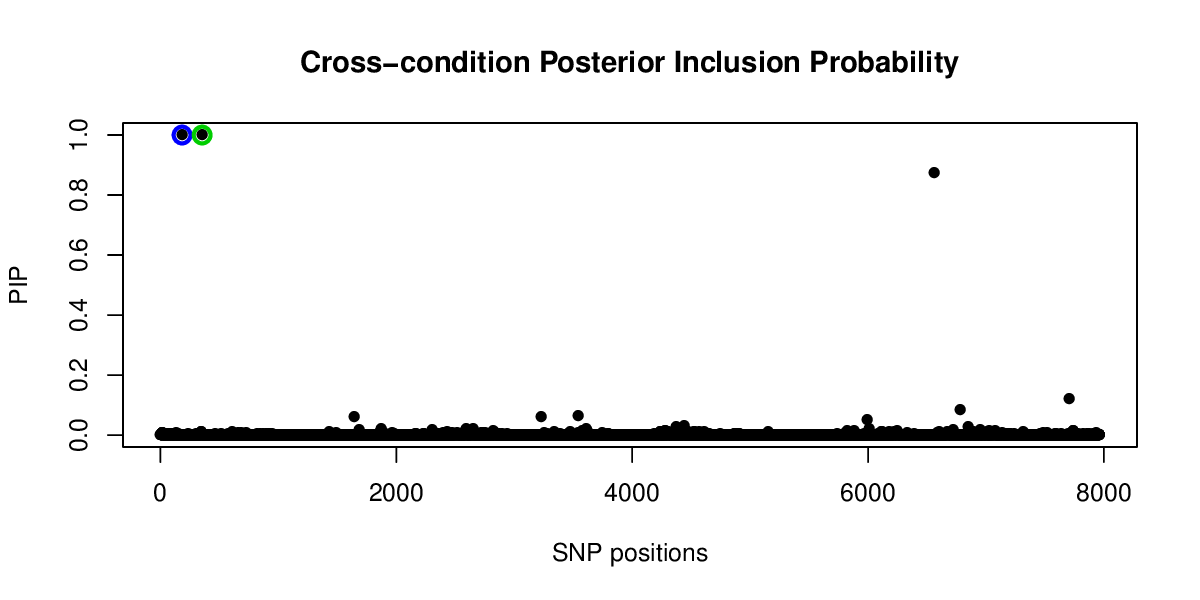

In [19]:
%preview susie_plot_toy.pdf -s png --dpi 150

> mmbr_plot_toy.pdf (5.0 KiB):

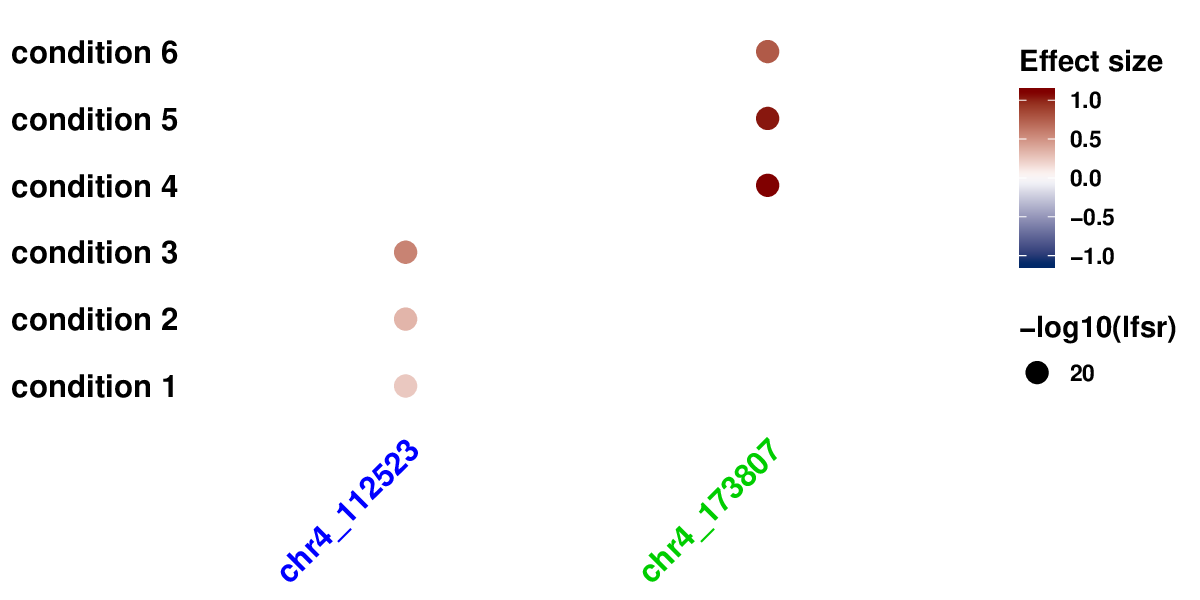

In [20]:
%preview mmbr_plot_toy.pdf -s png --dpi 150

In [21]:
colnames(genotype)[snp1]

[1] "chr4_112523_C_T_b38"

In [22]:
colnames(genotype)[snp2]

[1] "chr4_173807_A_G_b38"